# Random Forest

ref : https://www.kaggle.com/chalkalan/random-forest-tutorial

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor # import the random forest model
from sklearn import  preprocessing # used for label encoding and imputing NaNs

import datetime as dt # we will need this to convert the date to a number of days since some point

from sklearn.tree import export_graphviz
# import pydotplus
import six

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df_train = pd.read_csv('./train.csv', parse_dates=['timestamp'])
df_test = pd.read_csv('./test.csv', parse_dates=['timestamp'])
df_macro = pd.read_csv('./macro.csv', parse_dates=['timestamp'])

df_train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [4]:
# Create a vector containing the id's for our predictions
id_test = df_test.id

#Create a vector of the target variables in the training set
# Transform target variable so that loss function is correct (ie we use RMSE on transormed to get RMLSE)
# ylog1p_train will be log(1+y), as suggested by https://github.com/dmlc/xgboost/issues/446#issuecomment-135555130
ylog1p_train = np.log1p(df_train['price_doc'].values)
df_train = df_train.drop(["price_doc"], axis=1)

# Create joint train and test set to make data wrangling quicker and consistent on train and test
df_train["trainOrTest"] = "train"
df_test["trainOrTest"] = "test"
df_all = pd.concat([df_train, df_test])

# Removing the id (could it be a useful source of leakage?)
df_all = df_all.drop("id", axis=1)

In [5]:
# Convert the date into a number (of days since some point)
fromDate = min(df_all['timestamp'])
df_all['timedelta'] = (df_all['timestamp'] - fromDate).dt.days.astype(int)
print(df_all[['timestamp', 'timedelta']].head())
df_all.drop('timestamp', axis = 1, inplace = True)

   timestamp  timedelta
0 2011-08-20          0
1 2011-08-23          3
2 2011-08-27          7
3 2011-09-01         12
4 2011-09-05         16


In [6]:
for c in df_all.columns:
    if df_all[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_all[c].values)) 
        df_all[c] = lbl.transform(list(df_all[c].values))

In [7]:
# Create a list of columns that have missing values and an index (True / False)
df_missing = df_all.isnull().sum(axis = 0).reset_index()
df_missing.columns = ['column_name', 'missing_count']
idx_ = df_missing['missing_count'] > 0
df_missing = df_missing.ix[idx_]
cols_missing = df_missing.column_name.values
idx_cols_missing = df_all.columns.isin(cols_missing)

C:\Jam\Anaconda\envs\TF\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """


In [8]:
# Instantiate an imputer
imputer = preprocessing.Imputer(missing_values='NaN', strategy = 'most_frequent', axis = 0)

# Fit the imputer using all of our data (but not any dates)
imputer.fit(df_all.ix[:, idx_cols_missing])

# Apply the imputer
df_all.ix[:, idx_cols_missing] = imputer.transform(df_all.ix[:, idx_cols_missing])

C:\Jam\Anaconda\envs\TF\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Jam\Anaconda\envs\TF\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
C:\Jam\Anaconda\envs\TF\lib\site-packages\pandas\core\indexing.py:808: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
C:\Jam\Anaconda\envs\TF\lib\site-pa

In [9]:
df_all.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,trainOrTest,timedelta
0,43.0,27.0,4.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,...,4,0,13,22,1,0,52,4,1,0
1,34.0,19.0,3.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,...,3,0,15,29,1,10,66,14,1,3
2,43.0,29.0,2.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,...,3,0,11,27,0,4,67,10,1,7
3,89.0,50.0,9.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,...,2,1,4,4,0,0,26,3,1,12
4,77.0,77.0,4.0,17.0,1.0,2014.0,2.0,1.0,2.0,0,...,108,17,135,236,2,91,195,14,1,16


In [10]:
# Prepare separate train and test datasets
idx_train = df_all['trainOrTest'] == 1
idx_test = df_all['trainOrTest'] == 0

x_train = df_all[idx_train]
x_test = df_all[idx_test]

In [11]:
# Step 1: Instantiate a decision tree regressor
# Choose a depth for the tree - something 3, 4 or 5 - not too large
Model = DecisionTreeRegressor(max_depth = 3)

In [12]:
# Step 2: Train the tree
# The .fit method takes two main arguments, the features (in our case x_train) and 
# the target variable (in our case ylog1p_train)
# Fill them in below and submit the code to train the tree
Model.fit(X = x_train, y = ylog1p_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [13]:
# Step 3: Make predictions 
# The predict method takes one main argument - the examples for which
# we want to predict the target variable.  Here we will use the training data 
# itself i.e. x_train.  Fill this in below
ylog_pred = Model.predict(X = x_train)

In [14]:
# Check the training error

# Is the training error a reasonable estiamte of how this tree will perform on unseen data?
np.sqrt(np.mean((ylog_pred - ylog1p_train)**2))

0.5050585292848252

In [15]:
# Step 1: Instantiate a random forest regressor
Model = RandomForestRegressor(n_estimators = 30, 
                              random_state = 2017, 
                              oob_score = True, 
                              max_features = 20,
                              min_samples_leaf = 8)

In [16]:
# Step 2: Train the forest
# Again fill in X and y below with x_train and ylog1p_train
Model.fit(X = x_train, y = ylog1p_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=20, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=True, random_state=2017, verbose=0,
                      warm_start=False)

In [17]:
# Step 3: Make predictions 
# Create predictions for the examples in x_train
ylog_pred = Model.predict(X = x_train)

In [18]:
# Check the training error
np.sqrt(np.mean((ylog_pred - ylog1p_train)**2)) # about 0.37 (if you use 100 trees)

0.37598117525044705

In [19]:
np.sqrt(np.mean((Model.oob_prediction_ - ylog1p_train)**2)) # 0.47 slightly better than a simple tree.

0.47538145698220363

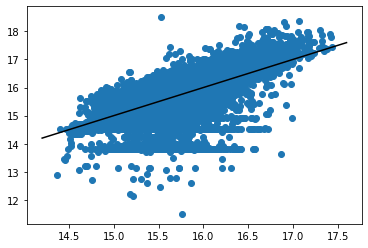

In [20]:
fig, ax = plt.subplots()
plt.scatter(Model.oob_prediction_, ylog1p_train)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color = 'black')
plt.show()

In [21]:
# Create a dataframe of the variable importances
df_ = pd.DataFrame(df_all.columns, columns = ['feature'])
df_['fscore'] = Model.feature_importances_[:, ]

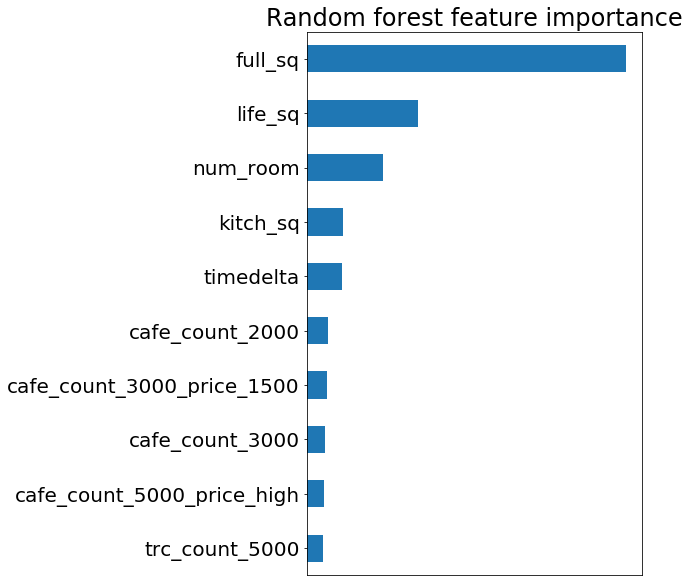

In [22]:
# Plot the relative importance of the top 10 features
df_['fscore'] = df_['fscore'] / df_['fscore'].max()
df_.sort_values('fscore', ascending = False, inplace = True)
df_ = df_[0:10]
df_.sort_values('fscore', ascending = True, inplace = True)
df_.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('Random forest feature importance', fontsize = 24)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks(fontsize=20)
plt.show()
#plt.gcf().savefig('feature_importance_xgb.png')

In [23]:
# Create the predictions

ylog_pred = Model.predict(x_test)
y_pred = np.exp(ylog_pred) - 1

In [24]:
output = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

output.to_csv('RandomForest_2.csv', index=False)